In [23]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [24]:
def load_sweep(path: str) -> pd.DataFrame:
    with open(path) as f:
        return pd.DataFrame.from_dict(
            dict(**line, **result)
            for line in filter(lambda d: "results" in d, map(json.loads, f))
            for result in line["results"]
        ).drop(columns=["results", "_duration"])


pd.concat([load_sweep(f) for f in Path("data").glob("*.jsonl")]).reset_index(
    drop=True
).drop(columns=["id", "output", "local_ratio", "prefill_length"]).groupby(
    ["dataset", "shots", "model_scale", "k", "sparsity"], dropna=False
).mean().reset_index().to_json(
    "summary.jsonl",
    orient="records",
    lines=True
)


In [25]:
df = pd.read_json("summary.jsonl", lines=True)

In [26]:
df

,dataset,shots,model_scale,k,sparsity,match
0,squad,1,1b,128.0,clustering,0.0550
1,squad,1,1b,128.0,clustering-weighted,0.0375
2,squad,1,1b,128.0,eviction,0.1175
3,squad,1,1b,256.0,clustering,0.0825
4,squad,1,1b,256.0,clustering-weighted,0.0725
5,squad,1,1b,256.0,eviction,0.1425
6,squad,1,1b,512.0,clustering,0.1525
7,squad,1,1b,512.0,clustering-weighted,0.1375
8,squad,1,1b,512.0,eviction,0.2025
9,squad,1,1b,NaN,none,0.3750


In [27]:
grouped = df.groupby("sparsity")

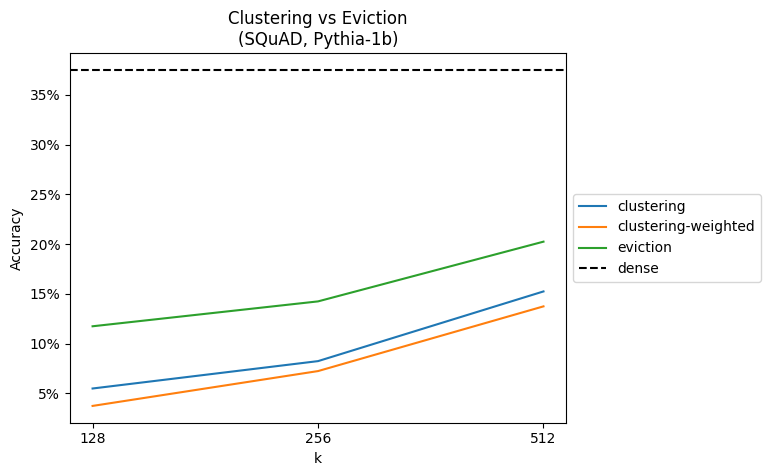

In [28]:
for sparsity, f in grouped:
    if sparsity == "none":
        plt.axhline(y = f["match"].item(), color = "black", linestyle="--", label="dense")
    else:
        plt.plot(f["k"], f["match"], label=sparsity)
plt.xscale("log", base=2)
ax = plt.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Clustering vs Eviction\n(SQuAD, Pythia-1b)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()